In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy.signal import savgol_filter

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data preprocessing

In [2]:
data_path = "../data/pilot-3d"

In [4]:
def merge_csv_files(data_path):
    dfs = []
    raw_data_path = os.path.join(data_path, 'raw')
    for file in os.listdir(raw_data_path):
        file_path = os.path.join(raw_data_path, file)
        if file_path.endswith('.txt'):
            print(file_path)
            dfs.append(pd.read_csv(file_path, sep='\t'))
    df_concat = pd.concat(dfs)
    df_concat.to_csv(os.path.join(data_path, 'raw_data_merged.csv'), index=False, sep='\t')

merge_csv_files(data_path = "../data/pilot-3d")

../data/pilot-3d\raw\437_1_2021_12_10_11_39.txt
../data/pilot-3d\raw\437_1_2021_12_10_12_19.txt
../data/pilot-3d\raw\452_1_2021_12_13_19_08.txt
../data/pilot-3d\raw\452_1_2021_12_13_21_27.txt
../data/pilot-3d\raw\452_2_2021_12_14_20_39.txt
../data/pilot-3d\raw\892_1_2021_12_14_08_36.txt
../data/pilot-3d\raw\892_2_2021_12_14_17_24.txt


In [3]:
def get_measures(traj):
    '''
    This function extracts dependent variables and some other useful things from an individual trajectory.
    The time of bot spawn is the first time bot_a is less than 10% of its max value (after the ego car slows
    down to 2 m/s).
    '''
    if sum(traj.ego_v<1.0):
        idx_slowdown = (traj.ego_v<1.0).to_numpy().nonzero()[0][0]
        idx_bot_spawn = traj.bot_x.to_numpy().nonzero()[0][0] + (traj[idx_slowdown:].bot_a<1).to_numpy().nonzero()[0][0]
        throttle = traj.iloc[idx_bot_spawn:, traj.columns.get_loc('throttle')]
        idx_response = idx_bot_spawn + (throttle>0).to_numpy().nonzero()[0][0]
        RT = traj.t.values[idx_response] - traj.t.values[idx_bot_spawn]
        idx_min_distance = idx_bot_spawn + np.argmin(traj.d_ego_bot[idx_bot_spawn:].values)
        min_distance = min(traj.d_ego_bot[idx_bot_spawn:].values)
    else:
        # if the driver never decelerated to <2m/s, the bot did not spawn
        idx_bot_spawn = -1
        idx_response = -1
        idx_min_distance = -1
        min_distance = -1
        RT = -1
    return pd.Series({'idx_bot_spawn': idx_bot_spawn,
                      'idx_response': idx_response,
                      'idx_min_distance': idx_min_distance,
                      'min_distance': min_distance,
                      'RT': RT})

def get_data(data_file='raw_data_merged.txt'):
    data = pd.read_csv(data_file, sep='\t', index_col=['subj_id', 'session', 'route', 'intersection_no'])

    data.loc[:,'t'] = data.t.groupby(data.index.names).transform(lambda t: (t-t.min()))

    data = data.rename(columns={'accl_profile_values': 'a_condition'})

    condition_map = {"[0.0, 0.0, 0.0, 0.0]": "Constant speed",
                 "[0.0, -3, 3, 0.0]": "Slight deceleration",
                 "[0.0, 3, -3, 0.0]": "Slight acceleration",
                 "[0.0, -5, 5, 0.0]": "Strong deceleration",
                 "[0.0, 5, -5, 0.0]": "Strong acceleration"}
    data['nudge_condition'] = data['a_condition'].map(condition_map)

    # we are only interested in left turns
    data = data[data.turn_direction==1]

    # discarding the filler trials
    data = data[data.d_condition==80]

    # only consider the data recorded within 10 meters of each intersection
    data = data[abs(data.ego_distance_to_intersection)<15]

    # smooth the time series by filtering out the noise using Savitzky-Golay filter
    apply_filter = lambda traj: savgol_filter(traj, window_length=21, polyorder=2, axis=0)
    cols_to_smooth = ['ego_x', 'ego_y', 'ego_vx', 'ego_vy', 'ego_ax', 'ego_ay',
                      'bot_x', 'bot_y', 'bot_vx', 'bot_vy', 'bot_ax', 'bot_ay']
    data.loc[:, cols_to_smooth] = (data.loc[:, cols_to_smooth].groupby(data.index.names).transform(apply_filter))

    # calculate absolute values of speed and acceleration
    data['ego_v'] = np.sqrt(data.ego_vx**2 + data.ego_vy**2)
    data['bot_v'] = np.sqrt(data.bot_vx**2 + data.bot_vy**2)
    data['ego_a'] = np.sqrt(data.ego_ax**2 + data.ego_ay**2)
    data['bot_a'] = np.sqrt(data.bot_ax**2 + data.bot_ay**2)

    # calculate actual distance between the ego vehicle and the bot, and current tta for each t
    data['d_ego_bot'] = np.sqrt((data.ego_x - data.bot_x)**2 + (data.ego_y - data.bot_y)**2)
    data['tta'] = data.d_ego_bot/data.bot_v

    # get the DVs and helper variables
    measures = data.groupby(data.index.names).apply(get_measures)
    print(measures.groupby(['subj_id', 'session', 'route']).size())

    data = data.join(measures)

    # RT is -1 if a driver didn't stop and the bot did not appear at the intersection; we discard these trials
    print('Number of discarded trials: %i' % (len(measures[measures.RT<=0])))
    print(measures[measures.RT<=0].groupby(['subj_id']).size())

    # data = data[data.RT>0]
    # measures = measures[measures.RT>0]

    # add the condition information to the measures dataframe for further analysis
    conditions = data.loc[:,['tta_condition', 'd_condition', 'a_condition', 'nudge_condition']].groupby(data.index.names).first()
    measures = measures.join(conditions)

    return data, measures


In [4]:
# merge_txt_files(data_path)
data, measures = get_data(os.path.join(data_path, 'raw_data_merged.csv'))

# is_turn_decision is calculated based on the minimum distance ever observed between ego and bot during the interaction.
# If the cars were no closer to each other than the lane width (3.5m + 1.5 margin), we count this as a turn decision.
# Based on visual inspection of animations for all trials, this works in all but one trials.
measures['is_turn_decision'] = measures.min_distance > 5

# In some trials this criterion wouldn't work, because e.g. a subject might hit a post after turning left,
# so that the bot is less than 5m away from the ego car after the turn. We need to check this and fix manually
# measures.loc[(305, 1, 1, 8), ['is_turn_decision']] = True

# add column 'decision' for nicer visualization
measures['decision'] = 'Stay'
measures.loc[measures.is_turn_decision, ['decision']] = 'Go'
measures["p_go_decision"] = measures.decision == "Go"

measures.to_csv(os.path.join(data_path, 'measures.csv'), index=True)
data.to_csv(os.path.join(data_path, 'processed_data.csv'), index=True)
measures = measures.reset_index()

subj_id  session  route
437      1        1        20
                  2        20
                  3        20
                  4        20
                  5        20
452      1        1        20
                  2        20
                  3        20
                  4        20
                  5        20
         2        6        20
                  7        20
                  8        20
                  9        20
                  10       20
892      1        1        20
                  2        20
                  3        20
                  4        20
                  5        20
         2        6        20
                  7        20
                  8        20
                  9        20
                  10       20
dtype: int64
Number of discarded trials: 10
subj_id
452    6
892    4
dtype: int64


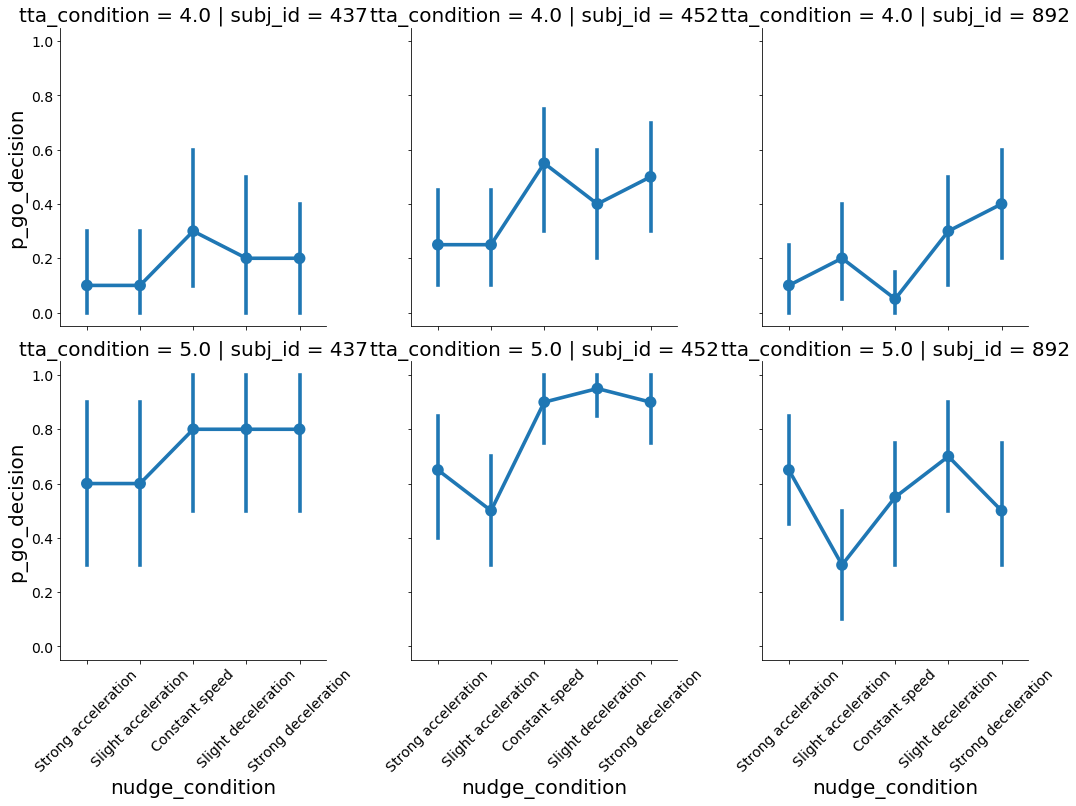

In [7]:
g = sns.catplot(data=measures, x="nudge_condition", y="p_go_decision",
                row="tta_condition", col="subj_id", kind="point",
            order=["Strong acceleration",
                   "Slight acceleration",
                   "Constant speed",
                   "Slight deceleration",
                   "Strong deceleration"])
for axes in g.axes:
    for ax in axes:
        ax.set_ylim((-0.05, 1.05))
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.savefig("../figures/p_turn_nudge_3d.png", bbox_inches='tight')

In [8]:
print(measures.groupby(['subj_id', 'tta_condition', 'nudge_condition']).size())

subj_id  tta_condition  nudge_condition    
437      4.0            Constant speed         10
                        Slight acceleration    10
                        Slight deceleration    10
                        Strong acceleration    10
                        Strong deceleration    10
         5.0            Constant speed         10
                        Slight acceleration    10
                        Slight deceleration    10
                        Strong acceleration    10
                        Strong deceleration    10
452      4.0            Constant speed         20
                        Slight acceleration    20
                        Slight deceleration    20
                        Strong acceleration    20
                        Strong deceleration    20
         5.0            Constant speed         20
                        Slight acceleration    20
                        Slight deceleration    20
                        Strong acceleration    20
      

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


(20, 28)

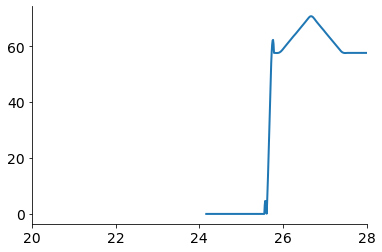

In [9]:
plt.plot(data.loc[452,1,1,1].t, 3.6*data.loc[452,1,1,1].bot_v)
plt.xlim((20, 28))

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


(-8, 8)

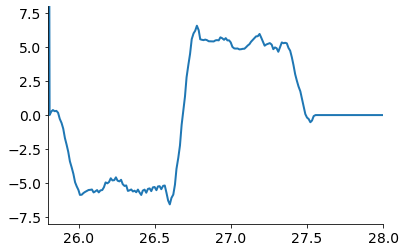

In [8]:
plt.plot(data.loc[452,1,1,1].t, data.loc[452,1,1,1].bot_ax)
plt.xlim((25.8, 28))
plt.ylim((-8, 8))